# LSTM_aug


## Mount Google Drive

In [2]:
# Colab 사용시
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install

In [3]:
# !java -version
# %pip install PyKomoran
%pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 3.7 MB/s 
     |████████████████████████████████| 453 kB 67.7 MB/s 


## Import Library

In [4]:
# data
import pandas as pd
import pickle

# preprocessing
from konlpy.tag import Komoran
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sn

# env
import os
from tqdm import tqdm
# import hangul_font

## GPU Setting

In [5]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


## Hyper_parameters

In [32]:
# Colab
DATA_DIR = '/content/drive/MyDrive/miso/sentiment/data/'
SAVE_DIR = '/content/drive/MyDrive/miso/sentiment/model/LSTM_aug/'
LOAD_DIR = '/content/drive/MyDrive/miso/sentiment/model/LSTM_aug/'

# Model
# MAX_LEN -> 패딩 단계에서 설정
OUTPUT_DIM = 256 #Embedding
UNITS = 128 #LSTM
DROPOUT = 0.2 #LSTM
#RECURRENT_DROPOUT = 0.2 #LSTM
OUTPUT = 6 #Dense

# Evaluation
EPOCHS = 10
VERBOSE = 1
BATCH_SIZE = 256
PATIENCE = 4
VALIDATION_SPLIT = 0.2

## Load Data

In [9]:
df = pd.read_csv(DATA_DIR + 'final_sentiment.csv')

In [10]:
df[:1]

,text,label
0,"어, 청소 니가 대신 해 줘!",angry


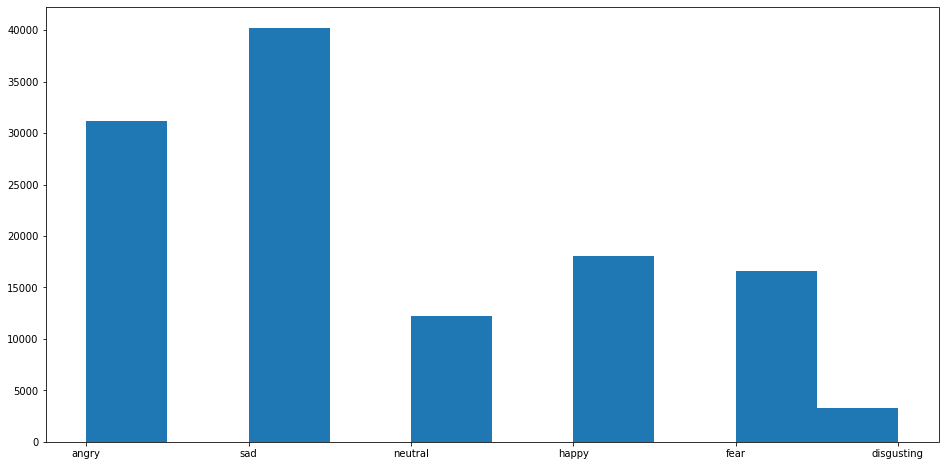

In [12]:
label = df['label']

plt.figure(figsize=(16, 8))
plt.hist(label)
plt.show()

### Train, Test split

In [13]:
X = df.text
y = df.label

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=34, stratify=y
)

In [14]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('\nX_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (97205,)
y_train shape:  (97205,)

X_test shape:  (24302,)
y_test shape:  (24302,)


## Train Data PreProcessing

### Tokenization

In [16]:
komoran = Komoran()

# 불용어(Stop Words) 제거
stop_pos_tags =  ['IC', 'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX',
                   'EF', 'ETN', 'ETM', 'XSA', 'SF', 'SP', 'SS', 'SE', 'SO', 'SL', 'SH',
                   'SW', 'NF', 'NV', 'SN', 'NA']

#어간 원형 복원 (Lemmatization)
#동사와 형용사의 경우에는 어간(Stem)에 '다'를 붙여서 기본형으로 복원
def tokenize(corpus, stop_pos_tags):
    result = []
    pairs = komoran.pos(corpus)
    for pair in pairs:
        morph, pos = pair
        if pos not in stop_pos_tags:
            if pos in ['VV', 'VA', 'VX', 'VCP', 'VCN']:
                morph = morph + '다'
            result.append(morph)
    return result

In [17]:
# 토큰을 만들고 리스트에 저장
clean_train_text = []
for sample in tqdm(X_train):
    clean_train_text.append(tokenize(sample, stop_pos_tags))

100%|██████████| 97205/97205 [00:53<00:00, 1810.24it/s]


In [18]:
clean_train_text[:3]

[['암',
  '떼다',
  '면',
  '재발',
  '확률',
  '적다',
  '다더니',
  '다른',
  '장기로',
  '전',
  '되다',
  '었',
  '너무',
  '슬프다'],
 ['벌써', '한', '시간', '째', '기다리다', '고', '있다', '것', '같다'],
 ['혼자',
  '자기',
  '관리',
  '하다',
  '며',
  '꾸준히',
  '한',
  '덕',
  '좋다',
  '결과',
  '나오다',
  '것',
  '같다',
  '어리다',
  '때',
  '자기',
  '주도',
  '학습',
  '습관',
  '기르다',
  '어',
  '주다',
  '었']]

## Test Data PreProcessing

### Tokenization

In [19]:
# 토큰을 만들고 리스트에 저장
clean_test_text = []
for sample in tqdm(X_test):
    clean_test_text.append(tokenize(sample, stop_pos_tags))

100%|██████████| 24302/24302 [00:13<00:00, 1788.75it/s]


### Vectorization

In [22]:
tokenizer_name = 'tokenizer.pickle'
save_path = os.path.join(SAVE_DIR, tokenizer_name)

tokenizer = Tokenizer(oov_token = True)

try:
    tokenizer.fit_on_texts(clean_train_text)
    train_sequences = tokenizer.texts_to_sequences(clean_train_text)
    test_sequences = tokenizer.texts_to_sequences(clean_test_text)
except:
    print('Already tokenized')

with open(save_path, 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

vocab_size = len(tokenizer.word_index)+1 # 단어의 수
vocab_size

train_sequences[:3]

[[418, 3351, 40, 1876, 3044, 558, 3140, 103, 6285, 149, 24, 6, 13, 111],
 [298, 57, 92, 509, 249, 4, 12, 17, 18],
 [126,
  223,
  394,
  3,
  396,
  858,
  57,
  1631,
  30,
  351,
  90,
  17,
  18,
  432,
  58,
  223,
  2877,
  3644,
  1057,
  2653,
  16,
  28,
  6]]

### Set vocab_size

In [23]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(VOCAB_SIZE)

12404


### Get vocab items

In [24]:
token_dic = tokenizer.word_counts
d2 = sorted(token_dic.items(), key=lambda x: x[1], reverse=True)
print("sorted")
print(d2)

sorted
[('하', 41928), ('하다', 34955), ('고', 29548), ('았', 27669), ('었', 22700), ('이다', 20292), ('나', 18519), ('게', 18109), ('는데', 17602), ('아', 16263), ('있다', 16131), ('너무', 15346), ('내', 14702), ('아서', 14245), ('어', 13607), ('것', 12528), ('같다', 12198), ('들', 11869), ('어서', 10820), ('보다', 10711), ('친구', 10586), ('없다', 10398), ('되다', 10356), ('지', 10299), ('안', 9883), ('겠', 9068), ('주다', 7604), ('않다', 7494), ('좋다', 7421), ('나다', 7046), ('일', 6815), ('거', 6373), ('사람', 5886), ('아야', 5779), ('가다', 5714), ('다', 5517), ('말', 5209), ('싶다', 5191), ('면', 5171), ('들다', 5136), ('잘', 5081), ('지다', 4997), ('수', 4911), ('생각', 4861), ('모르다', 4676), ('오다', 4612), ('받다', 4610), ('그렇다', 4473), ('힘들다', 4468), ('정말', 4425), ('되', 4348), ('많이', 3823), ('다고', 3736), ('회사', 3727), ('시', 3711), ('한', 3691), ('때', 3602), ('걱정', 3600), ('못', 3553), ('ㄴ데', 3544), ('걸다', 3477), ('더', 3339), ('그', 3254), ('집', 3225), ('지금', 3114), ('돈', 3102), ('마음', 3090), ('알다', 3059), ('오늘', 2986), ('먹다', 2956), ('요즘', 2950), (

### Padding

텍스트의 최대 길이 : 62
텍스트의 평균 길이 : 12.780834319222262


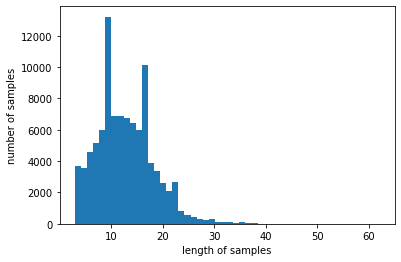

In [25]:
print('텍스트의 최대 길이 :',max(len(text) for text in train_sequences))
print('텍스트의 평균 길이 :',sum(map(len, train_sequences))/len(train_sequences))
plt.hist([len(text) for text in train_sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [26]:
trunc_type = 'post'
padding_type = 'post'
MAX_LEN = int(max(len(text) for text in train_sequences) * 95 / 100)

X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)
X_test= pad_sequences(test_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)

In [27]:
print(X_train[:3])

[[ 418 3351   40 1876 3044  558 3140  103 6285  149   24    6   13  111
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 298   57   92  509  249    4   12   17   18    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 126  223  394    3  396  858   57 1631   30  351   90   17   18  432
    58  223 2877 3644 1057 2653   16   28    6    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


### Labeling

In [28]:
y_train.unique()

array(['sad', 'angry', 'disgusting', 'happy', 'fear', 'neutral'],
      dtype=object)

In [29]:
emo_dic = {
    'angry': 0, 'disgusting': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5
}

In [30]:
y_train = y_train.replace(emo_dic)
y_test = y_test.replace(emo_dic)
y_train.unique()

array([5, 0, 1, 3, 2, 4])

## Model definition

In [34]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=OUTPUT_DIM, mask_zero=True, input_length=MAX_LEN))
model.add(LSTM(units=UNITS, dropout=DROPOUT))#, recurrent_dropout=RECURRENT_DROPOUT))
model.add(Dense(units=OUTPUT, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=VERBOSE, patience=PATIENCE, restore_best_weights=True)
mcp = ModelCheckpoint(SAVE_DIR + 'best-model.h5', monitor='val_accuracy', mode='max', verbose=VERBOSE, save_best_only=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train Model

In [ ]:
# CPU만 사용
# with tf.device('/CPU:0'):
#     history = model.fit(
#     X_train, y_train, epochs=EPOCHS, callbacks=[es, mc], batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

In [36]:
history = model.fit(
    X_train, y_train, epochs=EPOCHS, callbacks=[es,mcp], batch_size=BATCH_SIZE, validation_split=0.2
)

Epoch 1/10
301/304 [============================>.] - ETA: 0s - loss: 0.8125 - accuracy: 0.6978
Epoch 1: val_accuracy improved from -inf to 0.83571, saving model to /content/drive/MyDrive/miso/sentiment/model/LSTM_aug/best-model.h5
304/304 [==============================] - 22s 23ms/step - loss: 0.8096 - accuracy: 0.6989 - val_loss: 0.4574 - val_accuracy: 0.8357
Epoch 2/10
300/304 [============================>.] - ETA: 0s - loss: 0.3498 - accuracy: 0.8749
Epoch 2: val_accuracy improved from 0.83571 to 0.86009, saving model to /content/drive/MyDrive/miso/sentiment/model/LSTM_aug/best-model.h5
304/304 [==============================] - 4s 14ms/step - loss: 0.3502 - accuracy: 0.8746 - val_loss: 0.3840 - val_accuracy: 0.8601
Epoch 3/10
301/304 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.9084
Epoch 3: val_accuracy improved from 0.86009 to 0.86492, saving model to /content/drive/MyDrive/miso/sentiment/model/LSTM_aug/best-model.h5
304/304 [========================

### Visualization

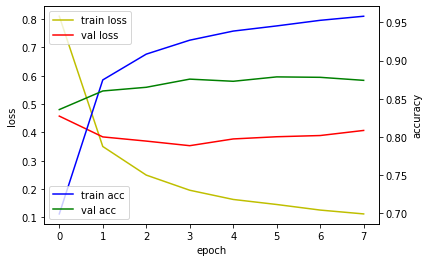

In [37]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Test Model

In [38]:
loaded_model = load_model(SAVE_DIR + 'best-model.h5')
loss, acc = loaded_model.evaluate(X_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', acc)

760/760 [==============================] - 5s 4ms/step - loss: 0.3838 - accuracy: 0.8737
Test loss: 0.38376572728157043
Test accuracy: 0.8736729621887207


## Save Model

In [39]:
model_name = 'trained-model.h5'

# Save model and weights
model_path = os.path.join(SAVE_DIR, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/miso/sentiment/model/LSTM_aug/trained-model.h5 


## Evaluation

confusion matrix

In [41]:
y_pred = loaded_model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)

[0 0 3 ... 4 2 0]


[[5683   25   78   74   62  320]
 [  61  504   12   13   39   28]
 [ 133   22 2746   59  104  249]
 [ 146    8   83 2978  121  269]
 [ 137   32   67  101 1906  193]
 [ 321    7  109  115   82 7415]]


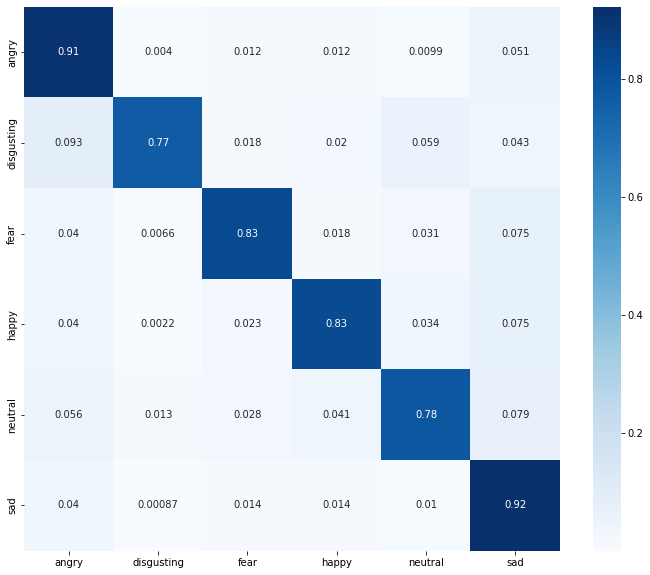

In [42]:
# constant for classes
classes = ('angry', 'disgusting', 'fear', 'happy', 'neutral', 'sad')

# Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/cf_matrix.sum(axis=1).reshape(6, 1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig(SAVE_DIR + '/output.png')

precision, recall, f1 score

In [43]:
acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred, average='macro')
re_score = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')
print("accuracy_score: ", acc_score)
print("precision_score: ", prec_score)
print("recall_score: ", re_score)
print("f1_score: ", f1_score)

accuracy_score:  0.8736729487284998
precision_score:  0.8662076503554514
recall_score:  0.8393603733593631
f1_score:  0.851873695675426


## Load Model

In [44]:
def load_tokenizer(path):
    with open(path, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer

model_name = 'trained-model.h5'
tokenizer_name = 'tokenizer.pickle'
model_path = os.path.join(LOAD_DIR, model_name)
tokenizer_path = os.path.join(LOAD_DIR, tokenizer_name)

model = load_model(model_path)
tokenizer = load_tokenizer(tokenizer_path)


In [45]:
def getResult(predict) :
    highest = 0
    highestIdx = 0
    for x in range (0,len(predict)) :
        if(predict[x] > highest) :
            highestIdx = x
            highest =predict[x]
    return highestIdx

def predict_sentiment(text, model):
    tokens = []
    tokenized = tokenize(text, stop_pos_tags)
    if(len(tokenized) == 0) :
        return "너무 짧아"
    tokens.append(tokenized)
    tokens = tokenizer.texts_to_sequences(tokens)
    x_test = pad_sequences(tokens, maxlen=MAX_LEN)
    predict = model.predict(x_test)
    # print(predict)
    result = getResult(predict[0])
    if result == 0 :
        return 'angry'
    elif result == 1 :
        return 'disgusting'
    elif result == 2 :
        return 'fear'
    elif result == 3 :
        return 'happy'
    elif result == 4 :
        return 'neutral'
    elif result == 5 :
        return 'sad'

# TEST

angry 라벨에 대한 예측

In [46]:
predict_sentiment("연락이 또 안돼. 짜증난다.", model)

'angry'

disgusting 라벨에 대한 예측

In [47]:
predict_sentiment("음식물 냄새가 너무 심해.", model)

'disgusting'

fear 라벨에 대한 예측

In [48]:
predict_sentiment("갑자기 사라질까봐 무서워.", model)

'fear'

happy라벨에 대한 예측

In [49]:
predict_sentiment("부모님께서 건강하다는 사실에 대해 감사하고 있어.", model)

'happy'

neutral라벨에 대한 예측

In [50]:
predict_sentiment("지금 밥 먹으러 가는중이야.", model)

'neutral'

sad라벨에 대한 예측

In [52]:
predict_sentiment("강아지가 세상을 떠났어.", model)

'sad'